# Clustering

Esta técinica de modelado buscará segmentar las resevras según sus comportamientos de consumo

## Contexto

Despues de aplicar técias de Data Governace en etapas anteriores del proyecto, nos encontramos con una tabla de reservaciones estructurada de la siguiente manera:

In [1]:
import pandas as pd

rsv = pd.read_csv('/Users/manuelrodriguez/Documents/Proyectos/Clustera/Data/Reservaciones.csv')
rsv.columns

Index(['ID_Reserva', 'Fecha_hoy', 'h_num_per', 'h_num_adu', 'h_num_men',
       'h_num_noc', 'h_tot_hab', 'ID_Tipo_Habitacion', 'ID_Pais_Origen',
       'h_edo', 'h_tfa_total', 'moneda_cve', 'Hotel_cve', 'Agencia_nombre',
       'Estado_cve', 'Tipo_Habitacion_nombre', 'Clasificacion',
       'Empresa_nombre', 'Franquicia', 'Paquete_nombre'],
      dtype='object')

A pesar de esto, pasaremos el dataframe a través de un nuevo proceso de selección y limpieza de variables enfocado a clustering

## Preprocesamiento

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

cols_clustering = ['h_num_per', 'h_num_adu', 'h_num_men', 'h_num_noc', 'ID_Tipo_Habitacion', 'Estado_cve', 'Paquete_nombre']

rsv_clustering = rsv[cols_clustering].copy()
rsv_clustering.dropna(inplace=True)

num_features = ['h_num_per', 'h_num_adu', 'h_num_men', 'h_num_noc']
cat_features = ['ID_Tipo_Habitacion', 'Estado_cve', 'Paquete_nombre']

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_features),
    ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_features)
])

X_scaled = preprocessor.fit_transform(rsv_clustering)

## GridSearch
Utilizaremos GridSearch para encontrara el número óptimo de clusters

/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarni

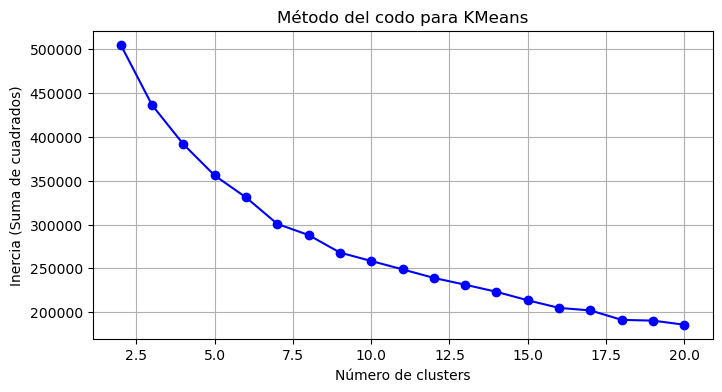

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K_range = range(2, 21)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Número de clusters')
plt.ylabel('Inercia (Suma de cuadrados)')
plt.title('Método del codo para KMeans')
plt.grid(True)
plt.show()

Podemos ver que el número ideal de K se encuntra en 9


In [4]:
optimal_k = 9

## Aplicación de modelos de Clustering
Aplicaremos diferentes métodos de Clustering, para después comparar sus desempeños y elegir el que mejor se adecúa a nuestro caso

## KMeans

In [5]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## DBSCAN

Se encontró que, debido a la dimensionalidad que maneja nuestra base de datos, DBSCAN no funcionará en nuestro caso específico
![Kernel Crasheado](/Users/manuelrodriguez/Documents/Proyectos/Clustera/Bcknd_resources/KerCrash.png)

## GMM 

In [6]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)


## Visualización y comparación de métricas

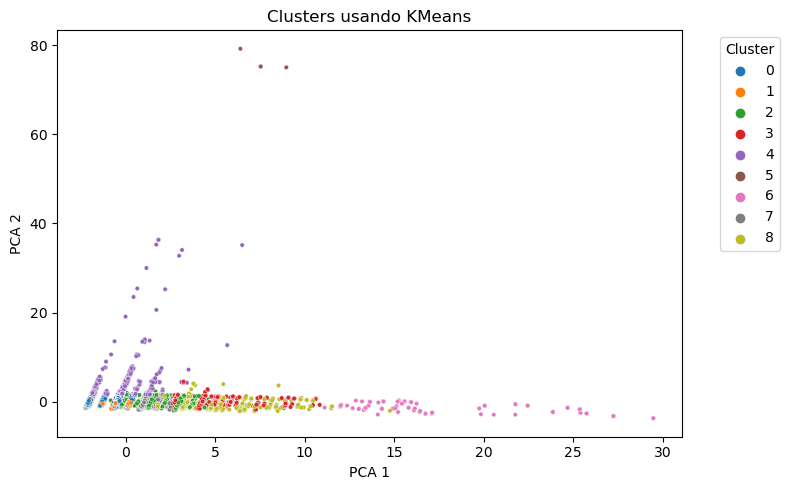

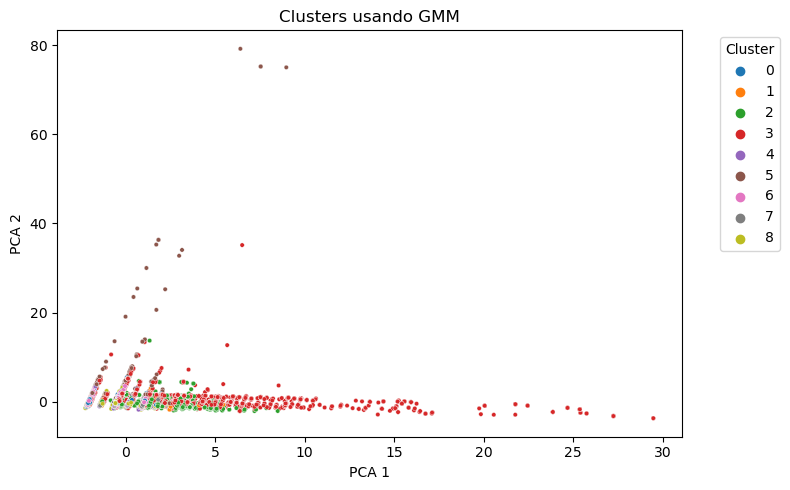

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="tab10", s=10, legend="full")
    plt.title(f"Clusters usando {title}")
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

plot_clusters(X_pca, kmeans_labels, "KMeans")
plot_clusters(X_pca, gmm_labels, "GMM")

In [8]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import numpy as np

def evaluar(labels, name):
    if len(set(labels)) > 1 and not (set(labels) == {-1}):  
        sil = silhouette_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
    else:
        sil = ch = db = np.nan
    return {
        "Algoritmo": name,
        "Silhouette": sil,
        "Calinski-Harabasz": ch,
        "Davies-Bouldin": db
    }

resultados = pd.DataFrame([
    evaluar(kmeans_labels, "KMeans"),
    evaluar(gmm_labels, "GMM")
])

print(resultados)

  Algoritmo  Silhouette  Calinski-Harabasz  Davies-Bouldin
0    KMeans    0.211116       17005.781338        1.233941
1       GMM    0.079693        5155.754138        2.530003


Podemos ver que, tanto visual como analíticamente, KMeans supera con creces a GMM, pero podemos ir un paso más alla y probar los siguientes algoritmos

## KMeans++

In [10]:
kmeans_pp = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
labels_kmeans_pp = kmeans_pp.fit_predict(X_scaled)

/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


## MiniBatch KMeans

In [11]:
from sklearn.cluster import KMeans, MiniBatchKMeans

mbkmeans = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, batch_size=100)
labels_mbkmeans = mbkmeans.fit_predict(X_scaled)

/Users/manuelrodriguez/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


## Visualización y comparación de métricas

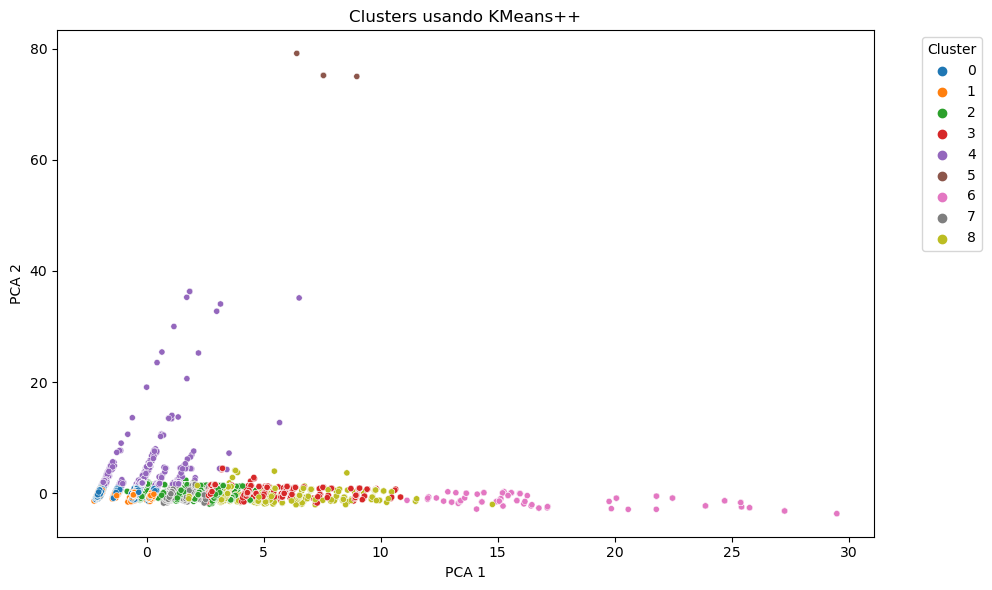

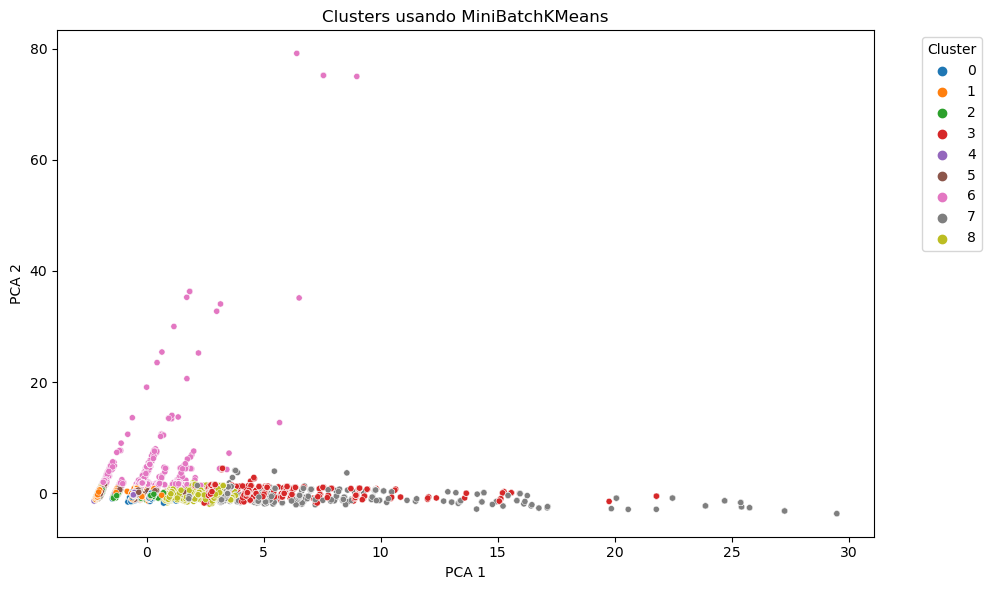

In [12]:
def plot_clusters(X_pca, labels, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette="tab10", s=20, legend='full')
    plt.title(title)
    plt.xlabel("PCA 1")
    plt.ylabel("PCA 2")
    plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

plot_clusters(X_pca, labels_kmeans_pp, "Clusters usando KMeans++")
plot_clusters(X_pca, labels_mbkmeans, "Clusters usando MiniBatchKMeans")

In [17]:
def evaluar2(labels, name):
    if len(set(labels)) > 1 and not (set(labels) == {-1}):  
        sil = silhouette_score(X_scaled, labels)
        ch = calinski_harabasz_score(X_scaled, labels)
        db = davies_bouldin_score(X_scaled, labels)
    else:
        sil = ch = db = np.nan
    return {
        "Algoritmo": name,
        "Silhouette": sil,
        "Calinski-Harabasz": ch,
        "Davies-Bouldin": db
    }

resultados_fase2 = pd.DataFrame([
    evaluar2(kmeans_labels, "KMeans"),
    evaluar2(labels_mbkmeans, "MiniBatchKMeans"),
    evaluar2(labels_kmeans_pp, "KMeans++"),
])

print(resultados_fase2)

         Algoritmo  Silhouette  Calinski-Harabasz  Davies-Bouldin
0           KMeans    0.211116       17005.781338        1.233941
1  MiniBatchKMeans    0.154398       12995.098523        1.760445
2         KMeans++    0.211116       17005.781338        1.233941
